In [1]:
import scvelo as scv
import scanpy as sc
import glob
from matplotlib import pyplot as plt
import sys
from pathlib import Path
import pandas as pd

def scv_velocity_on_embedding(f_embedding, LOOM, f_cell_cycle, fout_figure, markers=None):
    """\
    velocity plot on top of a given embedding (as csv file)
    Arguments
    ---------
    f_embedding:
        csv file with embedding (two columns represent coordinates). Row names should match cell names in loom
    LOOM:
        filename of a loom file OR AnnData object OR list of AnnData objects
    f_cell_cycle:
        file with a list of cell cycle genes to be gemoved from the analysis. Can be None.
    fout_figure:
        Output file to save the figure
    markers: (default: `None`)
        list of genes to include in velocity analysis. By default, all genes are considered.
    Returns
    -------
        `AnnData` object
    """
    print('Params:')
    print([f_embedding, LOOM, f_cell_cycle, fout_figure])
    print('Loading loom...')
    #path = Path(PATH)
    #print(path.parent+'loom')
    if isinstance(LOOM, sc.AnnData):
        adata_raw = LOOM
    elif isinstance(LOOM, list):
        l_adata = [scv.read(f_loom, sparse=True, cache=True) for f_loom in LOOM]
        adata_raw = l_adata[0]
        adata_raw = adata_raw.concatenate(l_adata[1:])

    else:
        f_loom = LOOM 
        print(f_loom)
        adata_raw = scv.read(f_loom, sparse=True, cache=True)

    if f_cell_cycle is None:
        cell_cycle_genes = []
    else:
        print('Loading cell cycle genes...')
        #cell_cycle_genes = pd.read_csv(f_cell_cycle).gene.ravel()
        cell_cycle_genes = [x.upper() for x in pd.read_csv(f_cell_cycle).gene.ravel()]
        print(cell_cycle_genes[:10])

    print('Loading embedding...')
    emb_csv = scv.read(f_embedding) 
    emb_csv.obs.index = [x.rstrip('-1') for x in emb_csv.obs.index]
    adata_raw.obs.index = [x.split('-')[0] for x in adata_raw.obs.index]

    print('Sample names in embedding:')
    print(emb_csv.obs.index[1:10])
    print('Sample names in loom:')
    print(adata_raw.obs.index[1:10])
    print('before filtering:')
    print(adata_raw.shape)
    
    shared_cells = list(set(emb_csv.obs.index).intersection( set(adata_raw.obs.index) ))
    print('Shared cells:')
    print(len(shared_cells))

    #emb_csv.obs.index
    adata = adata_raw[shared_cells].copy()
    adata.obsm['X_umap'] = emb_csv[shared_cells].X.copy()
    print('after cell filtering:')
    print(adata.shape)

    adata = adata[:, [x not in cell_cycle_genes for x in adata.var.index]]
    print('after removal of cell cycle genes:')
    print(adata.shape)

    if markers is not None:
        adata = adata[:, [x in markers for x in adata.var.index]]
        print('after removal of cell cycle genes:')
        print(adata.shape)


    print('Velocity...')
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=15, n_neighbors=30)

    scv.tl.recover_dynamics(adata)
    scv.tl.velocity(adata, mode='dynamical')
    scv.tl.velocity_graph(adata)

    print('Clustering...')
    scv.tl.louvain(adata)
    #sc.pl.umap(adata)

    print('Plot...')
    print(fout_figure)
    scv.pl.velocity_embedding_stream(adata, legend_loc='on data', basis='umap', dpi=400)#, save=fout_figure+'.stream.png')
    plt.savefig(fout_figure+'.stream.png')

    scv.pl.velocity_embedding_grid(adata, legend_loc='on data', basis='umap', dpi=400)#, save=fout_figure)
    plt.savefig(fout_figure)
    
    return adata


In [ ]:
'''%bash

gunzip -c 10x_70/outs/filtered_feature_bc_matrix/barcodes.tsv.gz > ../data/velocyto_mouse/10x_70/barcodes.tsv
cp -iv 10x_70/outs/possorted_genome_bam.bam ../data/velocyto_mouse/10x_70/
cp -iv 10x_results/10x_70/outs/possorted_genome_bam.bam.bai ../data/velocyto_mouse/10x_70/
samtools sort -m 1000M -t CB -O BAM -@ 10 -o ../data/velocyto_mouse/10x_70/cellsorted_possorted_genome_bam.bam ../data/velocyto_mouse/10x_70/possorted_genome_bam.bam
velocyto run -b ../data/velocyto_mouse/10x_70/barcodes.tsv -m mm10.rmsk.gtf ../data/velocyto_mouse/10x_70/possorted_genome_bam.bam mm10.gtf
'''

In [9]:
LOOM = [
 '../data/velocyto_mouse/possorted_genome_bam_2PPV2.loom']

LOOM_annot = ["X70"]

In [8]:
import scvelo as scv

l_adata = [scv.read(f_loom, sparse=True, cache=True) for f_loom in LOOM]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
# adding prefixes to cell names
for i in range(len(l_adata)):
    l_adata[i].obs.index = [LOOM_annot[i]+'_'+x.rstrip('x').split(':')[-1] for x in l_adata[i].obs.index]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.


Params:
['/mnt/data/artem/rdata/Adrenal/mouse_medulla.csv', AnnData object with n_obs × n_vars = 12747 × 31053 
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', None, 'velocity_mouse.cc.png']
Loading loom...
Loading embedding...
Sample names in embedding:
Index(['X70_AAAGAACGTGAGTTTC', 'X70_AAAGGGCCAATCGAAA', 'X70_AAAGGTACAGCTGTAT',
       'X70_AAAGTGACAAGATCCT', 'X70_AAATGGATCTGAGGCC', 'X70_AACAAAGCATCCGTTC',
       'X70_AACAAAGGTGACCTGC', 'X70_AACAAAGTCAGTAGGG', 'X70_AACAACCCACGTCTCT'],
      dtype='object')
Sample names in loom:
Index(['X70_AAACGAAAGACATCAA', 'X70_AAAGAACTCGACATAC', 'X70_AAAGTCCTCAATCGGT',
       'X70_AAACCCAAGAGGCTGT', 'X70_AAAGGATTCACGGGCT', 'X70_AAACGAACACGTAGTT',
       'X70_AAACGCTCACTGGATT', 'X70_AAACGCTTCATTTCGT', 'X70_AAACGCTCACCCAACG'],
      dtype='object')
before filtering:
(12747, 31053)
Shared cells:
1957
after cell filtering:
(1957, 31053)
after removal of cell cycle genes:
(1957, 3

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 23601 genes that are detected in less than 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
recovering dynamics
    finished (0:06:31) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Clustering...
Plot...
velocity_mouse.cc.png
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.ob

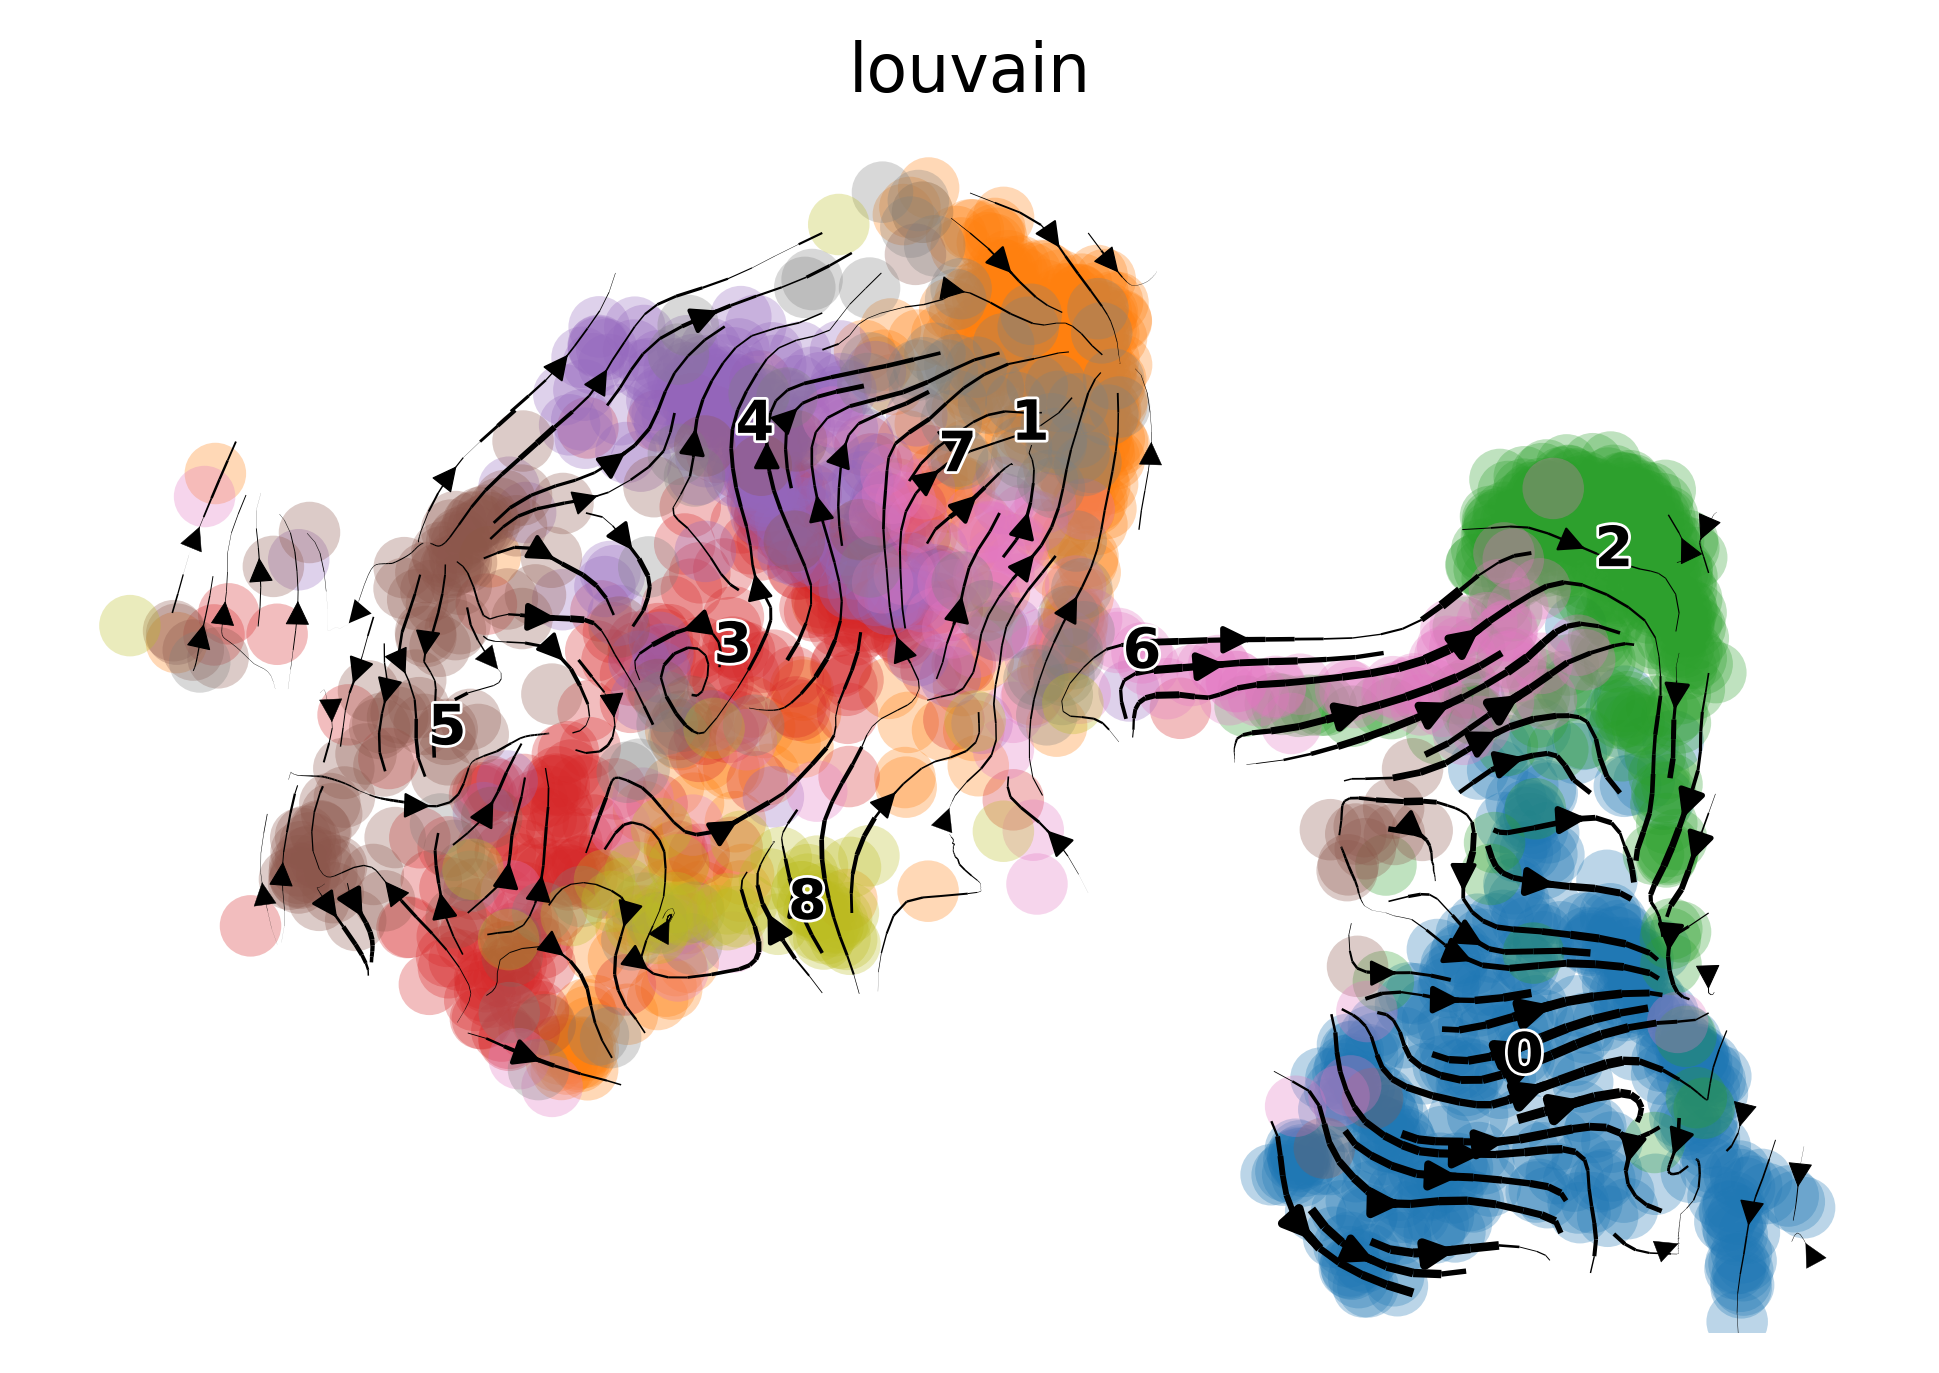

<Figure size 432x288 with 0 Axes>

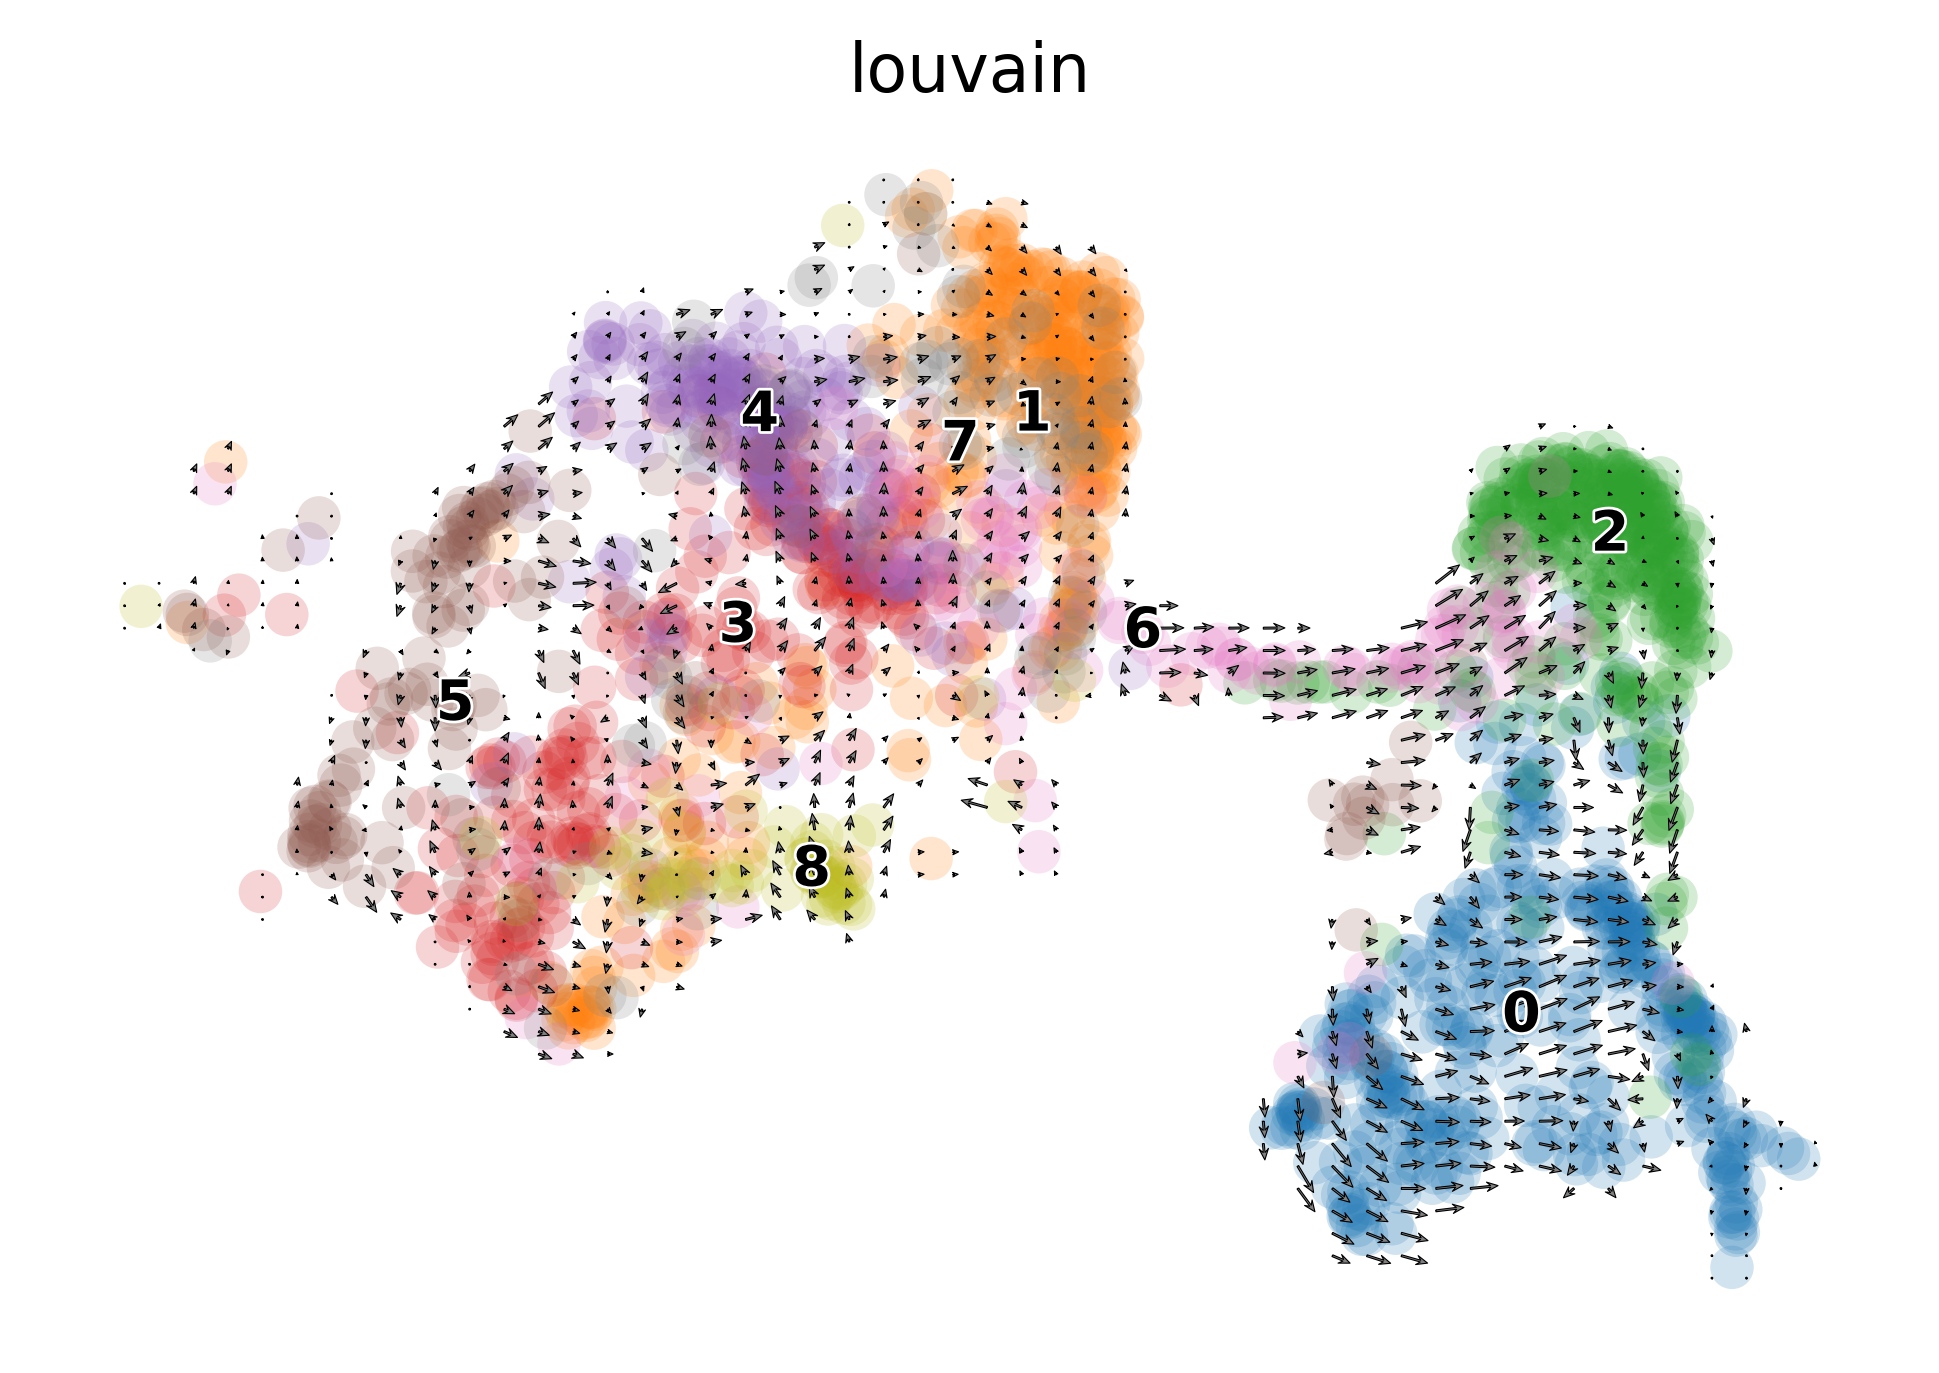

<Figure size 432x288 with 0 Axes>

In [12]:
adata_raw = l_adata[0]
import scanpy as sc
adata_raw = scv_velocity_on_embedding('../data/embeddings/mouse_medulla.csv', adata_raw, None, 'velocity_mouse.cc.png')


saving figure to file ./figures/scvelo_figures/fig2/medulla_mouse.velocity.5x5.png


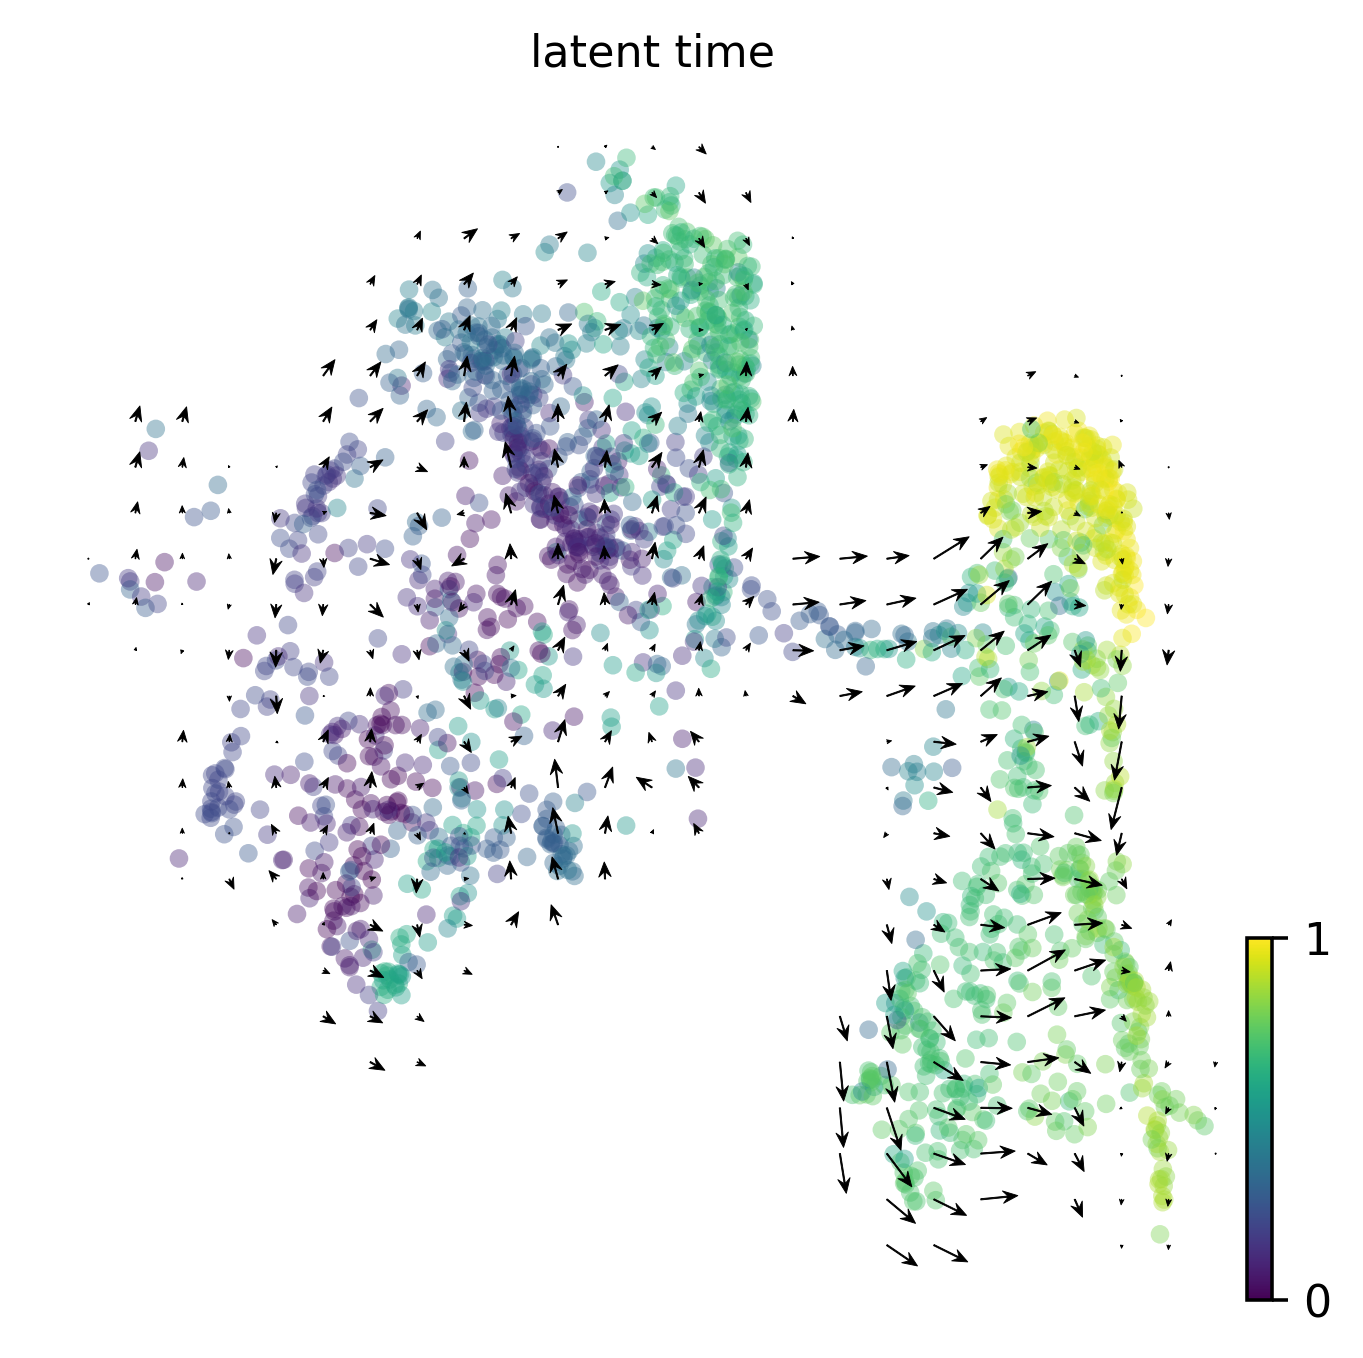

In [17]:
scv.tl.recover_latent_time(adata_raw)

scv.pl.velocity_embedding_grid(adata_raw, density=0.5, arrow_size=2, 
                               color='latent_time', basis='umap', dpi=320, color_map='viridis', 
                               size=70, alpha=0.4, arrow_color='black',
                               figsize=(5,5),
                               save='figures/fig2/medulla_mouse.velocity.5x5.png')


saving figure to file ./figures/scvelo_figures/fig2/medulla_mouse.Chga.velocity.5x5.png


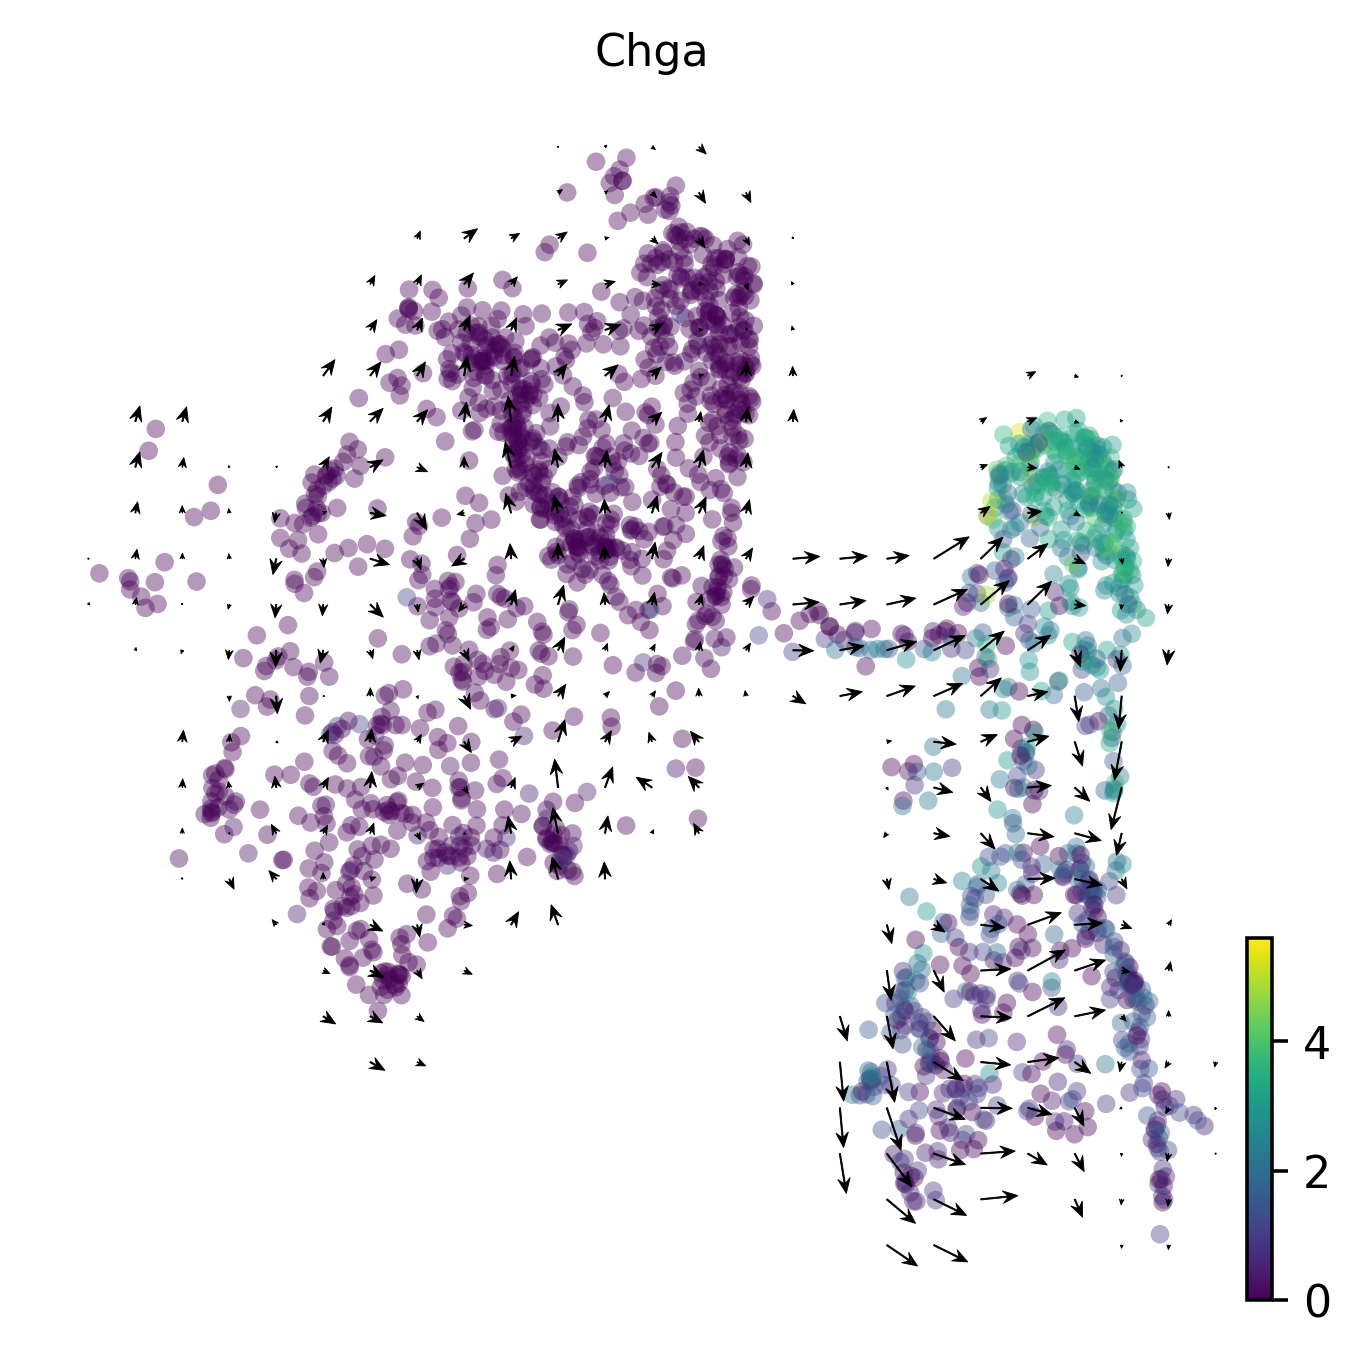

In [18]:
scv.pl.velocity_embedding_grid(adata_raw, density=0.5, arrow_size=2, 
                               color='Chga', basis='umap', dpi=320, color_map='viridis', 
                               size=70, alpha=0.4, arrow_color='black',
                               figsize=(5,5),
                               save='figures/fig2/medulla_mouse.Chga.velocity.5x5.png')
